<a href="https://colab.research.google.com/github/annien094/PINNs-tutorial-MICCAI-2024/blob/main/PINNs_ASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Welcome to the PINNs tutorial!**

In this notebook, we will set up a PINN and work through a problem on estimating cerebral perfusion (=cerebral blood flow, CBF) in an infant using data from arterial spin labelling (ASL) MRI.​ The model used is an ordinary differential equation (ODE).

# Setup

Let's install the required packages and gather the synthetic data and analytical solution for this tutorial.

### Install Packages
We will be using **DeepXDE**, a library dedicated for scientific machine learning and physics-informed learning. We will need to install a backend-specific dependency -- we use TensorFlow and Keras first (but can also be PyTorch, JAX, PaddlePaddle), and then DeepXDE. We also install Matplotlib for plotting.

In [ ]:
# Note: running on a CPU is sufficient for this tutorial
!pip install --upgrade tensorflow==2.17
!pip install --upgrade tensorflow-probability==0.24
!pip install --upgrade tf-keras==2.17
!pip install --upgrade deepxde==1.12.1
#!pip install --upgrade numpy
!pip install --upgrade matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.2/184.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 45.6 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


###Import packages
Import the installed packages and set the backend as TensorFlow.

In [ ]:
# Errors with GPUs can be ignored - we are running CPU only version
import os
os.environ['TF_USE_LEGACY_KERAS']='1'
os.environ['DDE_BACKEND'] = 'tensorflow' # We use TensorFlow as the backend for DeepXDE

import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
from deepxde.backend import tf

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


#Generate ASL Signal (Analytical Solution)

Here we initiate the model parameters, and implement the ground truth analytical solution for the ODE.

The signal calculation is divided into three parts based on different time conditions:
1.   Before arrival time (AT)
2.   During AT
3.   After AT (signal diffusion)

We also show a continuous analytical solution, in which the different branches are smoothed using a hyperbolic tangent function.

In [ ]:
class SignalData():

    def __init__(self, FA, T1b, T1t, blood_lambda, bolus_duration, dt, M0b, a,
                 cerebral_blood_flow, arrival_time, min_t, max_t):
        """
        Initialize the Signal class with the given parameters.

        Parameters
        ----------
        FA : float
            Flip angle in degrees.
        T1b : float
            T1 relaxation time of blood in ms.
        T1t : float
            T1 relaxation time of tissue in ms.
        blood_lambda : float
            Blood-brain partition coefficient.
        bolus_duration : float
            Bolus duration in seconds.
        dt : float, optional
            Time step size in ms.
        M0b : float
            Equilibrium magnetization of blood.
        a : float
            Labeling efficiency.
        cerebral_blood_flow : float
            Cerebral blood flow in mL/100g/min.
        arrival_time : List[float]
            List of arrival time values in ms.
        min_t : float
            Minimum time in ms.
        max_t : float
            Maximum time in ms.

        Returns
        -------
        None

        """
        self.FA_rads = np.deg2rad(FA)
        self.T1b_ms = T1b
        self.T1t_ms = T1t
        self.blood_lambda = blood_lambda
        self.bolus_duration_ms = bolus_duration
        self.dt_ms = dt
        self.M0b_au = M0b
        self.a = a

        self.cerebral_blood_flow = cerebral_blood_flow
        self.arrival_time = arrival_time

        self.min_t_ms = min_t
        self.max_t_ms = max_t


    def generate_time(self, time_range, samples):
        """
        Generate an array of time values within the specified range.

        Parameters
        ----------
        time_range : Tuple[float]
            A tuple representing the range of time values. The first element is the start time, and
            the second element is the end time.
        samples : int
            The number of samples to generate within the time range.

        Returns
        -------
        time : np.ndarray
            An array of time values evenly spaced within the specified range.

        """
        return np.linspace(start=time_range[0], stop=time_range[1], endpoint=True, num=samples)


    def buxton_signal(self, time):
        """
        Calculate the Buxton signal for a given time array.

        Parameters
        ----------
        time : np.ndarray
            The time array for which to calculate the Buxton signal.

        Returns
        -------
        delta_s : np.ndarray
            The calculated Buxton signal.

        """
        # t < ATT
        cond_1 = time < self.arrival_time
        ds_lower = np.zeros_like(time)

        # ATT <= t < ATT + bolus
        ds_range = self.M0b_au * self.a * self.cerebral_blood_flow * (time - self.arrival_time) * np.exp(-time / self.T1b_ms)

        # ATT + bolus <= t
        cond_3 = self.arrival_time + self.bolus_duration_ms <= time
        ds_upper = self.M0b_au * self.a * self.cerebral_blood_flow * self.bolus_duration_ms * np.exp(-time / self.T1b_ms)

        delta_s = np.where(cond_1, ds_lower, ds_range)
        delta_s = np.where(cond_3, ds_upper, delta_s)

        return delta_s


    @staticmethod
    def shift_tanh(x, shift=0, smooth=1):
        """
        Apply a shifted and smoothed hyperbolic tangent function to the input array.

        Parameters
        ----------
        x : np.ndarray
            The input array.
        shift : float, optional
            The shift value for the hyperbolic tangent function. The default is 0.
        smooth : float, optional
            The smoothing factor for the hyperbolic tangent function. The default is 1.

        Returns
        -------
        signal : np.ndarray
            The output array after applying the shifted and smoothed hyperbolic tangent function.
        """
        return 0.5 + 0.5 * np.tanh((x - shift) / smooth)


    @staticmethod
    def inverse_shift_tanh(x, shift=0, smooth=1):
        """
        Apply the inverse shift tanh function to the input array.

        Parameters
        ----------
        x : np.ndarray
            The input array.
        shift : float, optional
            The shift value. The default is 0.
        smooth : float, optional
            The smoothness parameter. The default is 1.

        Returns
        -------
        signal : np.ndarray
            The transformed array.

        """
        return 0.5 - 0.5 * np.tanh((x - shift) / smooth)


    def buxton_signal_continuous(self, time, smoothness=0.01):
        """
        Calculate the continuous Buxton signal.

        Parameters
        ----------
        time : np.ndarray
            Array of time values.
        smoothness : float, optional
            Smoothing parameter for the signal. The default is 0.01.

        Returns
        -------
        delta_s : np.ndarray
            Array of the calculated Buxton signal values.

        """
        # ATT <= t < ATT + bolus
        ds_range = self.M0b_au * self.a * self.cerebral_blood_flow * (time - self.arrival_time) * np.exp(-time / self.T1b_ms)

        # ATT + bolus <= t
        ds_upper = self.M0b_au * self.a * self.cerebral_blood_flow * self.bolus_duration_ms * np.exp(-time / self.T1b_ms)


        t_range = SignalData.shift_tanh(time, self.arrival_time, smoothness) * \
            SignalData.inverse_shift_tanh(time, self.bolus_duration_ms + self.arrival_time, smoothness)

        t_upper = SignalData.shift_tanh(time, self.bolus_duration_ms + self.arrival_time, smoothness)

        delta_s = t_range * ds_range + t_upper * ds_upper

        return delta_s


    def add_noise(self, signal, time, mean, std, seed=0) -> np.ndarray:
        """
        Add Gaussian noise to the input signal.

        Parameters
        ----------
        signal : np.ndarray
            The input signal to which noise will be added.
        time : np.ndarray
            The time array corresponding to the signal.
        mean : float
            The mean of the Gaussian noise distribution.
        std : float
            The standard deviation of the Gaussian noise distribution.
        seed : int, optional
            The seed value for the random number generator. Default is 0.

        Returns
        -------
        noisy_signal : np.ndarray
            The signal with added Gaussian noise.

        """
        rng = np.random.RandomState(seed)

        noise = rng.normal(mean, std, signal.shape)
        noisy_signal = np.copy(signal)
        noisy_signal += noise

        return noisy_signal

def get_values(seed=0):
    rng = np.random.RandomState(seed)

    values = {}
    values['FA'] = 32.45
    values['T1b'] = 2.0
    values['T1t'] = 1.7
    values['blood_lambda'] = 0.9
    values['bolus_duration'] = 0.6
    values['dt'] = 0.3
    values['M0b'] = 1.0
    values['a'] = 1.0
    values['CBF'] = rng.uniform(0.5, 1.0)
    values['AT'] = rng.uniform(0.15, 1.2)
    values['min_t'] = 0.0
    values['max_t'] = 3.6

    return values

# Generate example data
values = get_values(0)
signal_generator = SignalData(values['FA'], values['T1b'], values['T1t'], values['blood_lambda'],
                              values['bolus_duration'], values['dt'], values['M0b'], values['a'],
                              values['CBF'], values['AT'], values['min_t'], values['max_t'])
time = signal_generator.generate_time((values['min_t'], values['max_t']), int(values['max_t'] / values['dt']))
signal = signal_generator.buxton_signal(time)

plt.scatter(time, signal)
plt.xlabel('Time (s)')
plt.ylabel('Perfusion Weighted Image Signal')
plt.title('ASL Signal')
plt.show()

# PINNs Setup

**1:** Let's start by creating a function called **ode_system** that has time (*t*) and ASL signal (*y*) as inputs and returns the residual between *y* and the equation:
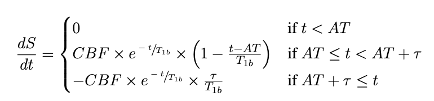

The DeepXDE functions jacobian and hessian may be useful - https://deepxde.readthedocs.io/en/latest/modules/deepxde.gradients.html.

In [ ]:
# @title Solution
def ode(time: tf.Tensor, cerebral_blood_flow: tf.Variable, arrival_time: tf.Variable,
            bolus_duration_ms: tf.Variable, T1b_ms: tf.Variable) -> tf.Tensor:
        """
        Compute the output of the Ordinary Differential Equation (ODE) for modeling cerebral blood flow.

        Parameters
        ----------
        time : tf.Tensor
            The time values at which to evaluate the ODE.
        cerebral_blood_flow : tf.Variable
            The cerebral blood flow value.
        arrival_time : tf.Variable
            The arrival time of the bolus.
        bolus_duration_ms : tf.Variable
            The duration of the bolus in milliseconds.
        T1b_ms : tf.Variable
            The relaxation time of blood in milliseconds.

        Returns
        -------
        results : tf.Tensor
            The computed results of the ODE.

        """
        cond_1 = tf.math.less(time, arrival_time)
        cond_3 = tf.math.less_equal(arrival_time + bolus_duration_ms, time)

        case_lower = tf.zeros_like(time, dtype=tf.float32)
        case_range = cerebral_blood_flow * tf.math.exp(-time / T1b_ms) * (1.0 - (time - arrival_time) / T1b_ms)
        case_upper = -cerebral_blood_flow * bolus_duration_ms / T1b_ms * tf.math.exp(-time / T1b_ms)

        results = tf.where(cond_1, tf.cast(case_lower, tf.float32), tf.cast(case_range, tf.float32))
        results = tf.where(cond_3, tf.cast(case_upper, tf.float32), tf.cast(results, tf.float32))

        return results


def ode_system(self, x: tf.Tensor, y: tf.Tensor) -> tf.Tensor:
        """
        Compute the error between the time derivative of the signal and the ODE model.

        Parameters
        ----------
        x : tf.Tensor
            The input tensor representing time.
        y : tf.Tensor
            The input tensor representing the signal.

        Returns
        -------
        error : tf.Tensor
            The tensor representing the error between the time derivative of the signal and the ODE model.

        """
        time = x
        signal = y

        ds_dt = dde.grad.jacobian(signal, time, i=0)

        if self.is_cbf_trainable:
            cbf = SystemDynamics.get_variable(self.cerebral_blood_flow)
        else:
            cbf = self.cerebral_blood_flow
        if self.is_at_trainable:
            at = SystemDynamics.get_variable(self.arrival_time)
        else:
            at = self.arrival_time
        if self.is_t1b_trainable:
            t1b = SystemDynamics.get_variable(self.T1b_ms)
        else:
            t1b = self.T1b_ms

        error = ds_dt - self.ode(time, cbf, at,
                                 self.bolus_duration_ms, t1b)

        return error

**2:** Now let's setup the FCNN to be used with PINNs. This will involve several steps:

*   Define the (time) domain of the solution with [```dde.geometry.TimeDomain```](https://deepxde.readthedocs.io/en/latest/modules/deepxde.geometry.html#module-deepxde.geometry.geometry_1d)
*   Create *net*, a FCNN architecture with 2 hidden layers with 32 neurons each, tanh activation functions and Glorot initialisation - using the *nn.FNN*
 function in DeepXDE



In [ ]:
# @title Solution
# Define the time domain
geometry = dde.geometry.TimeDomain(0, 1)

# Create net
layer_size = [1] + [32] * 2 + [1]
activation = 'tanh'
initializer = tf.keras.initializers.GlorotNormal(0)
net = dde.nn.FNN(layer_size, activation, initializer)

**3.** Now we need to:

* pass the experimental data to the PINNs, using [```dde.icbc.PointSetBC```](https://deepxde.readthedocs.io/en/latest/modules/deepxde.icbc.html)
* create an ```data``` object, specifying the

  *   time domain with ```geometry```
  *   equations with ```pde```
  *   training data with ```bcs```
  *   number of collocation points within the domain ```num_domain```
  *   number of collocation points for the boundary conditions  with ```num_boundary```
  *   extra training points in addition to ```num_boundary``` and ```num_domain with``` ```anchors```
  * solution of equations with ```solution```
  *   number of test points within the domain with ```num_test```.


We can then combine the data and the FNN using:

> ```model = dde.Model(data, net)```



In [ ]:
# @title Solution
# Prepare the data for the model to the appropriate shape
observe_time = time.reshape(-1, 1)
observe_signal = signal.reshape(-1, 1)

# Assign the training data
bcs = [dde.icbc.PointSetBC(observe_time, observe_signal, component=0, shuffle=False)]
data = dde.data.PDE(geometry=geometry, pde=ode_system,
                    bcs=bcs, num_domain=observe_time.shape[0], num_boundary=10,
                    anchors=observe_time, solution=signal_generator.buxton_signal_continuous, num_test=10)
# Prepare the initial condition

model = dde.Model(data, net)

**5:** Finally, we compile and train PINNs. Let's use Adam with a learning rate of 0.001 and a MSE loss with equal weights for all terms.

In [ ]:
# @title Solution
# Optimize the PINN
learning_rate = 1e-3
iterations = 10000

model.compile('adam', lr=learning_rate, loss='MSE', external_trainable_variables=trainable_variables)
losshistory, train_state = model.train(iterations=iterations, display_every=1000,
                                       callbacks=callback_variables)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

# Set which paramters the model should learn
is_cbf_trainable = False
is_at_trainable = False
is_t1b_trainable = False
print('Estimated parameters:')
print(f'CBF True: {true_cbf}; Predicted: {system_dynamics.cerebral_blood_flow.numpy() if is_cbf_trainable else system_dynamics.cerebral_blood_flow}')
print(f'AT True: {true_at}; Predicted: {system_dynamics.arrival_time.numpy() if is_at_trainable else system_dynamics.arrival_time}')
print(f'T1b True: {true_t1b}; Predicted: {system_dynamics.T1b_ms.numpy() if is_t1b_trainable else system_dynamics.T1b_ms}')


# Forward Mode PINNs Training

Below is a complete implementation of the PINNs setup for this problem. It includes Fourier input features and a tanh-based smoothing function for the different branches.

We suggest you run the full code and explore the following questions:


*   How much does the loss vary from run to run because of different initialisations?
*   What happens when changing the learning rate and network size?
*   Is the performance affected by rescaling the data/ODE to change the y dynamic range?
*   How are the results affected by noise and the smoothness of the different branches of the PDE?


Compiling model...
'compile' took 0.004101 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.37e-01, 5.22e-01]    [1.63e-01, 5.22e-01]    []  
1000      [5.14e-04, 1.80e-05]    [6.46e-04, 1.80e-05]    []  
2000      [4.04e-04, 1.48e-05]    [4.48e-04, 1.48e-05]    []  
3000      [3.46e-04, 1.37e-05]    [3.78e-04, 1.37e-05]    []  
4000      [1.97e-04, 1.11e-05]    [2.19e-04, 1.11e-05]    []  
5000      [4.02e-05, 8.03e-06]    [3.68e-05, 8.03e-06]    []  
6000      [3.11e-05, 7.59e-06]    [3.66e-05, 7.59e-06]    []  
7000      [2.29e-05, 7.81e-06]    [2.55e-05, 7.81e-06]    []  
8000      [1.74e-05, 7.64e-06]    [2.13e-05, 7.64e-06]    []  
9000      [1.31e-05, 7.72e-06]    [1.62e-05, 7.72e-06]    []  
10000     [1.08e-05, 8.59e-06]    [1.20e-05, 8.59e-06]    []  

Best model at step 10000:
  train loss: 1.93e-05
  test loss: 2.06e-05
  test metric: []

'train' took 19.196424 s



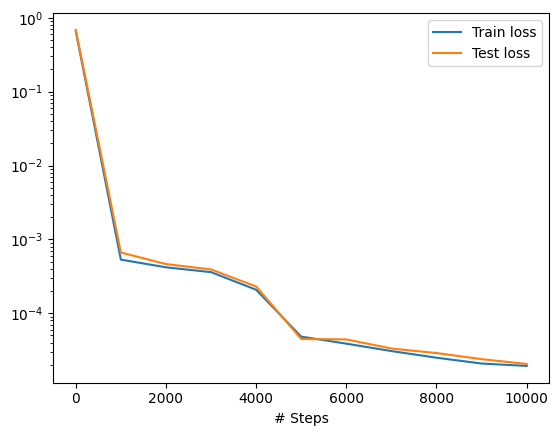

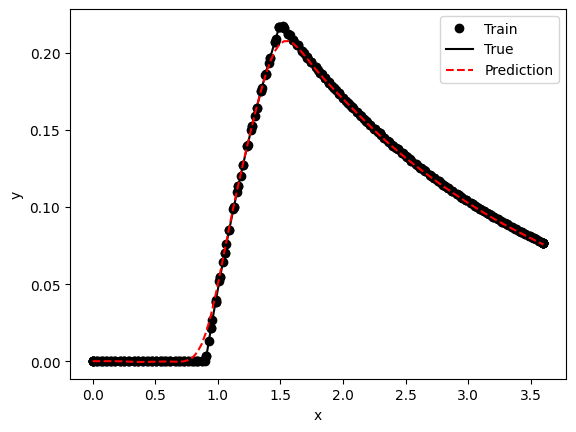

Estimated parameters:


In [ ]:
# Set which paramters the model should learn
is_cbf_trainable = False
is_at_trainable = False
is_t1b_trainable = False

# Generate a synthetic signal
# Exercise: Increase the white noise to the signal to make it a more challenging problem
add_noise = False
noise_std = 0.1
seed = 0

class SignalData():

    def __init__(self, FA, T1b, T1t, blood_lambda, bolus_duration, dt, M0b, a,
                 cerebral_blood_flow, arrival_time, min_t, max_t):
        """
        Initialize the Signal class with the given parameters.

        Parameters
        ----------
        FA : float
            Flip angle in degrees.
        T1b : float
            T1 relaxation time of blood in ms.
        T1t : float
            T1 relaxation time of tissue in ms.
        blood_lambda : float
            Blood-brain partition coefficient.
        bolus_duration : float
            Bolus duration in seconds.
        dt : float, optional
            Time step size in ms.
        M0b : float
            Equilibrium magnetization of blood.
        a : float
            Labeling efficiency.
        cerebral_blood_flow : float
            Cerebral blood flow in mL/100g/min.
        arrival_time : List[float]
            List of arrival time values in ms.
        min_t : float
            Minimum time in ms.
        max_t : float
            Maximum time in ms.

        Returns
        -------
        None

        """
        self.FA_rads = np.deg2rad(FA)
        self.T1b_ms = T1b
        self.T1t_ms = T1t
        self.blood_lambda = blood_lambda
        self.bolus_duration_ms = bolus_duration
        self.dt_ms = dt
        self.M0b_au = M0b
        self.a = a

        self.cerebral_blood_flow = cerebral_blood_flow
        self.arrival_time = arrival_time

        self.min_t_ms = min_t
        self.max_t_ms = max_t


    def generate_time(self, time_range, samples):
        """
        Generate an array of time values within the specified range.

        Parameters
        ----------
        time_range : Tuple[float]
            A tuple representing the range of time values. The first element is the start time, and
            the second element is the end time.
        samples : int
            The number of samples to generate within the time range.

        Returns
        -------
        time : np.ndarray
            An array of time values evenly spaced within the specified range.

        """
        return np.linspace(start=time_range[0], stop=time_range[1], endpoint=True, num=samples)


    def buxton_signal(self, time):
        """
        Calculate the Buxton signal for a given time array.

        Parameters
        ----------
        time : np.ndarray
            The time array for which to calculate the Buxton signal.

        Returns
        -------
        delta_s : np.ndarray
            The calculated Buxton signal.

        """
        # t < ATT
        cond_1 = time < self.arrival_time
        ds_lower = np.zeros_like(time)

        # ATT <= t < ATT + bolus
        ds_range = self.M0b_au * self.a * self.cerebral_blood_flow * (time - self.arrival_time) * np.exp(-time / self.T1b_ms)

        # ATT + bolus <= t
        cond_3 = self.arrival_time + self.bolus_duration_ms <= time
        ds_upper = self.M0b_au * self.a * self.cerebral_blood_flow * self.bolus_duration_ms * np.exp(-time / self.T1b_ms)

        delta_s = np.where(cond_1, ds_lower, ds_range)
        delta_s = np.where(cond_3, ds_upper, delta_s)

        return delta_s


    @staticmethod
    def shift_tanh(x, shift=0, smooth=1):
        """
        Apply a shifted and smoothed hyperbolic tangent function to the input array.

        Parameters
        ----------
        x : np.ndarray
            The input array.
        shift : float, optional
            The shift value for the hyperbolic tangent function. The default is 0.
        smooth : float, optional
            The smoothing factor for the hyperbolic tangent function. The default is 1.

        Returns
        -------
        signal : np.ndarray
            The output array after applying the shifted and smoothed hyperbolic tangent function.
        """
        return 0.5 + 0.5 * np.tanh((x - shift) / smooth)


    @staticmethod
    def inverse_shift_tanh(x, shift=0, smooth=1):
        """
        Apply the inverse shift tanh function to the input array.

        Parameters
        ----------
        x : np.ndarray
            The input array.
        shift : float, optional
            The shift value. The default is 0.
        smooth : float, optional
            The smoothness parameter. The default is 1.

        Returns
        -------
        signal : np.ndarray
            The transformed array.

        """
        return 0.5 - 0.5 * np.tanh((x - shift) / smooth)


    def buxton_signal_continuous(self, time, smoothness=0.01):
        """
        Calculate the continuous Buxton signal.

        Parameters
        ----------
        time : np.ndarray
            Array of time values.
        smoothness : float, optional
            Smoothing parameter for the signal. The default is 0.01.

        Returns
        -------
        delta_s : np.ndarray
            Array of the calculated Buxton signal values.

        """
        # ATT <= t < ATT + bolus
        ds_range = self.M0b_au * self.a * self.cerebral_blood_flow * (time - self.arrival_time) * np.exp(-time / self.T1b_ms)

        # ATT + bolus <= t
        ds_upper = self.M0b_au * self.a * self.cerebral_blood_flow * self.bolus_duration_ms * np.exp(-time / self.T1b_ms)


        t_range = SignalData.shift_tanh(time, self.arrival_time, smoothness) * \
            SignalData.inverse_shift_tanh(time, self.bolus_duration_ms + self.arrival_time, smoothness)

        t_upper = SignalData.shift_tanh(time, self.bolus_duration_ms + self.arrival_time, smoothness)

        delta_s = t_range * ds_range + t_upper * ds_upper

        return delta_s


    def add_noise(self, signal, time, mean, std, seed=0) -> np.ndarray:
        """
        Add Gaussian noise to the input signal.

        Parameters
        ----------
        signal : np.ndarray
            The input signal to which noise will be added.
        time : np.ndarray
            The time array corresponding to the signal.
        mean : float
            The mean of the Gaussian noise distribution.
        std : float
            The standard deviation of the Gaussian noise distribution.
        seed : int, optional
            The seed value for the random number generator. Default is 0.

        Returns
        -------
        noisy_signal : np.ndarray
            The signal with added Gaussian noise.

        """
        rng = np.random.RandomState(seed)

        noise = rng.normal(mean, std, signal.shape)
        noisy_signal = np.copy(signal)
        noisy_signal += noise

        return noisy_signal

def get_values(seed=0):
    rng = np.random.RandomState(seed)

    values = {}
    values['FA'] = 32.45
    values['T1b'] = 2.0
    values['T1t'] = 1.7
    values['blood_lambda'] = 0.9
    values['bolus_duration'] = 0.6
    values['dt'] = 0.3
    values['M0b'] = 1.0
    values['a'] = 1.0
    values['CBF'] = rng.uniform(0.5, 1.0)
    values['AT'] = rng.uniform(0.15, 1.2)
    values['min_t'] = 0.0
    values['max_t'] = 3.6

    return values

# Generate example data
values = get_values(0)
signal_generator = SignalData(values['FA'], values['T1b'], values['T1t'], values['blood_lambda'],
                              values['bolus_duration'], values['dt'], values['M0b'], values['a'],
                              values['CBF'], values['AT'], values['min_t'], values['max_t'])
time = signal_generator.generate_time((values['min_t'], values['max_t']), int(values['max_t'] / values['dt']))
signal = signal_generator.buxton_signal(time)

class PINN():

    def input_transform(self, t):
        """
        Applies a transformation to the input tensor.

        Parameters
        ----------
        t : tf.Tensor
            The input tensor.

        Returns
        -------
        transformed_t : tf.Tensor
            The transformed tensor.

        """
        return tf.concat(
            (
                t,
                tf.sin(t),
                tf.sin(2 * t)
            ),
            axis=1,
        )


    def output_transform(self, t, y):
        """
        Transforms the output of the model.

        Parameters
        ----------
        t : tf.Tensor
            The input tensor.
        y : tf.Tensor
            The output tensor.

        Returns
        -------
        transformed_t : tf.Tensor
            The transformed output tensor.

        """
        return tf.concat([y * tf.tanh(t)], axis=1)


    def get_network(self, input_transform=True, output_transform=True):
        """
        Returns a fully connected neural network (FNN) model.

        Parameters
        ----------
        input_transform : bool, optional
            Whether to apply input transformation to the network. The default is True.
        output_transform : bool, optional
            Whether to apply output transformation to the network. The default is True.

        Returns
        -------
        net : dde.nn.FNN
            The fully connected neural network model.

        """
        layer_size = [1] + [32] * 2 + [1]
        activation = 'tanh'
        initializer = tf.keras.initializers.GlorotNormal(0)
        net = dde.nn.FNN(layer_size, activation, initializer)

        if input_transform:
            net.apply_feature_transform(self.input_transform)
        if output_transform:
            net.apply_output_transform(self.output_transform)

        return net

class SystemDynamics():

    def set_configuration(self, config, is_cbf_trainable=False,
                          is_at_trainable=False, is_t1b_trainable=False,
                          smoothness=0.1):
        """
        Set the configuration parameters for the model.

        Parameters
        ----------
        config : Dict[str, float]
            The configuration dictionary containing the model parameters.
        is_cbf_trainable : bool, optional
            Flag indicating whether the cerebral blood flow parameter is trainable. Default is False.
        is_at_trainable : bool, optional
            Flag indicating whether the arrival time parameter is trainable. Default is False.
        is_t1b_trainable : bool, optional
            Flag indicating whether the T1b parameter is trainable. Default is False.
        smoothness : float, optional
            The smoothness parameter for the continous ODE. Default is 0.1.

        Returns
        -------
        None

        """
        if is_cbf_trainable:
            self.cerebral_blood_flow = dde.Variable(config['CBF'])
        else:
            self.cerebral_blood_flow = config['CBF']

        if is_at_trainable:
            self.arrival_time = dde.Variable(config['AT'])
        else:
            self.arrival_time = config['AT']

        if is_t1b_trainable:
            self.T1b_ms = dde.Variable(config['T1b'])
        else:
            self.T1b_ms = config['T1b']

        self.FA_rads = np.deg2rad(config['FA'])
        self.T1t_ms = config['T1t']
        self.blood_lambda = config['blood_lambda']
        self.bolus_duration_ms = config['bolus_duration']
        self.dt_ms = config['dt']
        self.M0b_au = config['M0b']
        self.a = config['a']
        self.min_t_ms = config['min_t']
        self.max_t_ms = config['max_t']

        self.smoothness = smoothness

        self.is_cbf_trainable = is_cbf_trainable
        self.is_at_trainable = is_at_trainable
        self.is_t1b_trainable = is_t1b_trainable


    def time_domain(self):
        """
        Create a time domain geometry object.

        Returns
        -------
        geometry : dde.geometry.TimeDomain
            The time domain geometry object.

        """
        geometry = dde.geometry.TimeDomain(self.min_t_ms, self.max_t_ms)
        return geometry


    @staticmethod
    def get_variable(var):
        """
        Apply the ReLU activation function to the given tensor.

        Parameters
        ----------
        var : tf.Tensor
            The input tensor.

        Returns
        -------
        tf.Tensor
            The tensor after applying the ReLU activation function.

        """
        return tf.keras.activations.relu(var, threshold=1e-2, max_value=2.5)


    @staticmethod
    def shift_tanh(x, shift=0, smooth=1):
        """
        Applies a shifted and smoothed hyperbolic tangent function to the input tensor.

        Parameters
        ----------
        x : tf.Tensor
            The input tensor.
        shift : float, optional
            The shift value to be applied to the input tensor. The default is 0.
        smooth : float, optional
            The smoothing factor to be applied to the input tensor. The default is 1.

        Returns
        -------
        shifted : tf.Tensor
            The tensor with the shifted and smoothed hyperbolic tangent function applied.

        """
        return 0.5 + 0.5 * tf.math.tanh((x - shift) / smooth)


    @staticmethod
    def inverse_shift_tanh(x, shift=0, smooth=1):
        """
        Applies the inverse shift tanh function to the input tensor.

        Parameters
        ----------
        x : tf.Tensor
            The input tensor.
        shift : float, optional
            The shift value. The default is 0.
        smooth : float, optional
            The smoothness parameter. The default is 1.

        Returns
        -------
        shifted : tf.Tensor
            The transformed tensor.

        """
        return 0.5 - 0.5 * tf.math.tanh((x - shift) / smooth)


    @staticmethod
    def ode_continuous(time, cerebral_blood_flow, arrival_time, bolus_duration_ms,
                       T1b_ms, smoothness) -> tf.Tensor:
        """
        Calculate the continuous solution of the ordinary differential equation
        (ODE) for cerebral blood flow.

        Parameters
        ----------
        time : tf.Tensor
            The time points at which to evaluate the ODE.
        cerebral_blood_flow : tf.Variable
            The cerebral blood flow variable.
        arrival_time : tf.Variable
            The arrival time of the bolus.
        bolus_duration_ms : tf.Variable
            The duration of the bolus in milliseconds.
        T1b_ms : tf.Variable
            The relaxation time of blood in milliseconds.
        smoothness : float
            The smoothness parameter for the shift-tanh function.

        Returns
        -------
        results : tf.Tensor
            The continuous solution of the ODE.

        """
        t_range = SystemDynamics.shift_tanh(time, arrival_time, smoothness) * \
            SystemDynamics.inverse_shift_tanh(time, bolus_duration_ms + arrival_time, smoothness)
        case_range = cerebral_blood_flow * tf.math.exp(-time / T1b_ms) * (1.0 - (time - arrival_time) / T1b_ms)

        t_upper = SystemDynamics.shift_tanh(time, bolus_duration_ms + arrival_time, smoothness)
        case_upper = -cerebral_blood_flow * bolus_duration_ms / T1b_ms * tf.math.exp(-time / T1b_ms)

        results = t_range * case_range + t_upper * case_upper

        return results


    def ode_system_continuous(self, x: tf.Tensor, y: tf.Tensor) -> tf.Tensor:
        """
        Compute the continuous ordinary differential equation (ODE) system.

        Parameters
        ----------
        x : tf.Tensor
            The independent variable of the ODE system.
        y : tf.Tensor
            The dependent variable of the ODE system.

        Returns
        -------
        error : tf.Tensor
            The error between the computed ODE system and the actual ODE system.

        """
        time = x
        signal = y

        ds_dt = dde.grad.jacobian(signal, time, i=0)

        if self.is_cbf_trainable:
            cbf = SystemDynamics.get_variable(self.cerebral_blood_flow)
        else:
            cbf = self.cerebral_blood_flow
        if self.is_at_trainable:
            at = SystemDynamics.get_variable(self.arrival_time)
        else:
            at = self.arrival_time
        if self.is_t1b_trainable:
            t1b = SystemDynamics.get_variable(self.T1b_ms)
        else:
            t1b = self.T1b_ms

        error = ds_dt - self.ode_continuous(time, cbf, at,
                                            self.bolus_duration_ms, t1b,
                                            self.smoothness)

        return error

num_samples = 100

values = get_values(seed)
signal_generator = SignalData(values['FA'], values['T1b'], values['T1t'], values['blood_lambda'],
                              values['bolus_duration'], values['dt'], values['M0b'], values['a'],
                              values['CBF'], values['AT'], values['min_t'], values['max_t'])
time = signal_generator.generate_time((values['min_t'], values['max_t']), num_samples)
signal = signal_generator.buxton_signal(time)
if add_noise:
    signal = signal_generator.add_noise(signal, time, mean=0, std=noise_std, seed=seed)

# Store the true values
true_cbf = values['CBF']
true_at = values['AT']
true_t1b = values['T1b']
# If they are learnable set them to some fixed value
if is_cbf_trainable:
    values['CBF'] = 0.5
if is_at_trainable:
    values['AT'] = 0.5
if is_t1b_trainable:
    values['T1b'] = 1.5

# Prepare the model
system_dynamics = SystemDynamics()
system_dynamics.set_configuration(values, is_cbf_trainable, is_at_trainable, is_t1b_trainable)
geometry = system_dynamics.time_domain()
net = PINN().get_network(input_transform=True, output_transform=True)

ode = system_dynamics.ode_system_continuous
solution = signal_generator.buxton_signal_continuous

# Set the learnable parameters
trainable_variables = []
callback_variables = []
if is_cbf_trainable:
    trainable_variables.append(system_dynamics.cerebral_blood_flow)
if is_at_trainable:
    trainable_variables.append(system_dynamics.arrival_time)
if is_t1b_trainable:
    trainable_variables.append(system_dynamics.T1b_ms)
if is_cbf_trainable or is_at_trainable or is_t1b_trainable:
    callback_variables.append(dde.callbacks.VariableValue(trainable_variables,
                                                          period=100,
                                                          filename=None,
                                                          precision=8))

# Prepare the data for the model
observe_time = time.reshape(-1, 1)
observe_signal = signal.reshape(-1, 1)
# Prepare the initial condition
bcs = [dde.icbc.PointSetBC(observe_time, observe_signal, component=0, shuffle=False)]
data = dde.data.PDE(geometry=system_dynamics.time_domain(), pde=ode,
                    bcs=bcs, num_domain=observe_time.shape[0], num_boundary=10,
                    anchors=observe_time, solution=solution, num_test=10)

model = dde.Model(data, net)

# Optimize the PINN
# Exercise: Tune the parameters as needed
learning_rate = 1e-3
iterations = 10000

model.compile('adam', lr=learning_rate, loss='MSE', external_trainable_variables=trainable_variables)
losshistory, train_state = model.train(iterations=iterations, display_every=1000,
                                       callbacks=callback_variables)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)
print('Estimated parameters:')
if is_cbf_trainable:
  print(f'CBF True: {true_cbf}; Predicted: {system_dynamics.cerebral_blood_flow.numpy() if is_cbf_trainable else system_dynamics.cerebral_blood_flow}')
if is_at_trainable:
  print(f'AT True: {true_at}; Predicted: {system_dynamics.arrival_time.numpy() if is_at_trainable else system_dynamics.arrival_time}')
if is_t1b_trainable:
  print(f'T1b True: {true_t1b}; Predicted: {system_dynamics.T1b_ms.numpy() if is_t1b_trainable else system_dynamics.T1b_ms}')
